# NLP Analysis of WiMLDS Event Titles

### Date Created
19-May-2019

### Date Updated
18-Jun-2019

### Reference 1:  Topic Modeling with Gensim (Python)
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

>Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. This tutorial attempts to tackle both of these problems.

## Import Packages
The core packages used in this tutorial are `re`, `gensim`, `spacy` and `pyLDAvis`. Besides this we will also using `matplotlib`, `numpy` and `pandas` for data handling and visualization. Let’s import them.

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime
    
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import sys
print("Python Version:", sys.version)

Python Version: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import matplotlib

In [4]:
matplotlib.__version__

'2.2.2'

In [5]:
pd.__version__

'0.23.0'

## Read in data


In [6]:
df_events = pd.read_csv('wimlds_events_2019_05_08.csv')

In [7]:
len(df_events)

439

In [8]:
list(df_events)

['chapter_name', 'link', 'local_date', 'name', 'yes_rsvp_count']

In [9]:
len(df_events.chapter_name.unique())

43

In [10]:
df_events.local_date.min()

'1/10/19'

In [11]:
df_events.local_date.max()

'9/8/18'

In [12]:
df_events['event_date'] =  pd.to_datetime(df_events['local_date'], format='%x')

In [13]:
df_events.event_date.min()

Timestamp('2014-01-23 00:00:00')

In [14]:
df_events.event_date.max()

Timestamp('2019-05-07 00:00:00')

In [15]:
df_events.head(10)

,chapter_name,link,local_date,name,yes_rsvp_count,event_date
0,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,3/10/18,Big Data: From Chaos to Intelligence,17,2018-03-10
1,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,5/5/18,Machine Learning: A Focus on Supervised and Un...,35,2018-05-05
2,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,7/21/18,Deep Learning: Build An Image Classification M...,20,2018-07-21
3,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,6/24/17,NLP: Zero to one,59,2017-06-24
4,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,8/5/17,Handling Imbalanced Datasets: Building a model...,63,2017-08-05
5,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,11/25/17,The ABC-XYZ of Data Science before Machine Lea...,50,2017-11-25
6,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,12/8/16,Uncovering patterns and trends using explorato...,17,2016-12-08
7,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,1/28/17,Extracting Your Own Web Data using Scraping Tools,8,2017-01-28
8,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,2/25/17,TensorFlow Post-Summit Event,95,2017-02-25
9,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,3/25/17,Fueling the Artificial Intelligence revolution...,35,2017-03-25


In [16]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [17]:
# Convert to list
data = df_events.name.values.tolist()

In [18]:
data

['Big Data: From Chaos to Intelligence',
 'Machine Learning: A Focus on Supervised and Unsupervised Learning',
 'Deep Learning: Build An Image Classification Model',
 'NLP: Zero to one',
 'Handling Imbalanced Datasets: Building a model and deploying to production',
 'The ABC-XYZ of Data Science before Machine Learning',
 'Uncovering patterns and trends using exploratory data analysis',
 'Extracting Your Own Web Data using Scraping Tools',
 'TensorFlow Post-Summit Event',
 'Fueling the Artificial Intelligence revolution with gaming!',
 'Sentiment Analysis in R',
 'Unravelling Intel Deep Learning SDK',
 'TensorFlow : Zero to One',
 'Treasure Island: Bioinformatics for everyone.',
 'Deep Learning for Crypt-analysis using TensorFlow',
 'Prototyping Back Propagation in Excel For Greater Good',
 'Data Science and Machine Learning in Practice',
 '#NairobiWiMLDS turns 1 + Christmas Party',
 'Around the world of data science in 60 minutes or less',
 'TensorFlow Series: Convolutional Neural Netw

In [19]:
len(data)

439

## Tokenize words and Clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s `simple_preprocess()` is great for this. Additionally I have set `deacc=True` to remove the punctuations.

In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:3])

[['big', 'data', 'from', 'chaos', 'to', 'intelligence'], ['machine', 'learning', 'focus', 'on', 'supervised', 'and', 'unsupervised', 'learning'], ['deep', 'learning', 'build', 'an', 'image', 'classification', 'model']]


## Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s `Phrases` model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to `Phrases` are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.



In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['the', 'abc', 'xyz', 'of', 'data_science', 'before', 'machine_learning']


/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [23]:
print([bigram_mod[data_words[50]]])

[['everything_ml']]


## Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.



In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Let's call the functions in order

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [26]:
print(data_lemmatized[:2])

[['big_data', 'chaos', 'intelligence'], ['machine_learn', 'focus', 'supervise', 'unsupervised', 'learning']]


## 11. Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary (`id2word`) and the corpus. Let’s create them.

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
pprint(corpus[:20])

[[(0, 1), (1, 1), (2, 1)],
 [(3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)],
 [(13, 1)],
 [(12, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)],
 [(5, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)],
 [(22, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(32, 1), (33, 1), (34, 1), (35, 1)],
 [(36, 1), (37, 1), (38, 1), (39, 1)],
 [(21, 1), (40, 1)],
 [(10, 1), (41, 1), (42, 1), (43, 1)],
 [(35, 1)],
 [(44, 1), (45, 1), (46, 1), (47, 1)],
 [(10, 1), (21, 1), (27, 1), (35, 1), (48, 1)],
 [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1)],
 [(5, 1), (20, 1), (54, 1)],
 [(55, 1), (56, 1), (57, 1), (58, 1)],
 [(20, 1), (59, 1), (60, 1), (61, 1)],
 [(9, 1), (11, 1), (35, 1), (62, 1), (63, 1), (64, 1)]]


In [28]:
len(id2word)

779

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [29]:
id2word[0]

'big_data'

In [30]:
id2word[5]

'machine_learn'

In [31]:
id2word[1]

'chaos'

In [32]:
id2word[99]

'evaluation'

Or, you can see a human-readable form of the corpus itself.

In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('big_data', 1), ('chaos', 1), ('intelligence', 1)],
 [('focus', 1),
  ('learning', 1),
  ('machine_learn', 1),
  ('supervise', 1),
  ('unsupervised', 1)],
 [('build', 1),
  ('classification', 1),
  ('deep_learn', 1),
  ('image', 1),
  ('model', 1)],
 [('nlp', 1)],
 [('model', 1),
  ('building', 1),
  ('dataset', 1),
  ('deploy', 1),
  ('handle', 1),
  ('imbalanced', 1),
  ('production', 1)]]

## 12. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, `alpha` and `eta` are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

`chunksize` is the number of documents to be used in each training chunk. `update_every` determines how often the model parameters should be updated and `passes` is the total number of training passes.

### trying 40 topics

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## 13. View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()` as shown next.

In [35]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(27,
  '0.044*"bayesian" + 0.044*"testing" + 0.044*"inference" + 0.018*"imbalanced" '
  '+ 0.018*"building" + 0.018*"dataset" + 0.018*"handle" + 0.018*"production" '
  '+ 0.018*"deploy" + 0.001*"model"'),
 (37,
  '0.074*"data" + 0.029*"nyu" + 0.029*"public" + 0.029*"pictalhealth" + '
  '0.029*"mccurdy" + 0.029*"katie" + 0.029*"sosulski" + 0.029*"artist" + '
  '0.029*"enigma" + 0.029*"kristen"'),
 (30,
  '0.073*"new" + 0.032*"idea" + 0.032*"viral" + 0.032*"tortilla" + '
  '0.032*"generator" + 0.032*"dinner" + 0.032*"lecture" + 0.032*"waterworks" + '
  '0.032*"drink" + 0.025*"jam"'),
 (18,
  '0.099*"nyc" + 0.054*"round" + 0.054*"datathon" + 0.037*"register" + '
  '0.037*"sap" + 0.027*"grace" + 0.027*"celebration" + 0.027*"hopper" + '
  '0.001*"data_dinner" + 0.001*"discussion"'),
 (29,
  '0.130*"fireside_chat" + 0.107*"halifax" + 0.043*"learning" + 0.031*"real" + '
  '0.031*"interactive" + 0.031*"ponder" + 0.031*"predictability" + '
  '0.013*"unsupervised" + 0.013*"focus" + 0.013*"super

## 14. Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.106196208717681

Coherence Score:  0.474268219628527


## 15. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.094685 -0.277588       1        1  8.180817
14     0.366182  0.088090       2        1  5.641088
26     0.041005 -0.139984       3        1  4.407352
34     0.040849 -0.194833       4        1  4.099218
10    -0.025324  0.011589       5        1  3.907581
5     -0.022224 -0.028439       6        1  3.718352
9      0.000952 -0.064351       7        1  3.644141
17    -0.021191 -0.015935       8        1  3.547110
31     0.017158 -0.093022       9        1  3.536769
19     0.198411  0.089125      10        1  3.409728
21    -0.020896 -0.007141      11        1  3.374761
35    -0.017527 -0.024920      12        1  3.337110
38     0.114624  0.038167      13        1  2.985983
32    -0.039273  0.014006      14        1  2.841563
7     -0.002935 -0.044702      15        1  2.827383
16     0.021302 -0.097844      16        1  2.757585
20    -0.039365  0.020636      17        1  2.621492
33    -0.038733  0.014231      18        1  2.166626
28    -0.030261 -0.005458      19        1  2.096732
4     -0.039805  0.014476      20        1  2.005591
23    -0.014818  0.002462      21        1  1.980488
8      0.084220  0.092219      22        1  1.960451
12    -0.047868  0.034097      23        1  1.927727
13    -0.039890  0.025158      24        1  1.883925
25    -0.025927  0.041349      25        1  1.839375
36    -0.036209  0.016430      26        1  1.825109
0     -0.051873  0.036155      27        1  1.721184
6     -0.046408  0.029768      28        1  1.700746
2     -0.048646  0.036143      29        1  1.566577
1     -0.045056  0.030519      30        1  1.524912
30    -0.054810  0.042446      31        1  1.392659
39    -0.021030 -0.041341      32        1  1.377081
37    -0.052481  0.040698      33        1  1.337539
22    -0.040850  0.033848      34        1  1.274078
15    -0.046998  0.033675      35        1  1.174795
29    -0.051051  0.039240      36        1  1.001453
3     -0.053314  0.042815      37        1  0.989962
24     0.099768  0.085069      38        1  0.870882
18    -0.051931  0.040460      39        1  0.835124
27    -0.052465  0.042688      40        1  0.708947, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
67    Default  48.000000              code  48.000000  30.0000  30.0000
20    Default  49.000000      data_science  49.000000  29.0000  29.0000
5     Default  31.000000     machine_learn  31.000000  28.0000  28.0000
109   Default  25.000000             wimld  25.000000  27.0000  27.0000
22    Default  22.000000             datum  22.000000  26.0000  26.0000
149   Default  27.000000             woman  27.000000  25.0000  25.0000
89    Default  19.000000                ai  19.000000  24.0000  24.0000
116   Default  16.000000          workshop  16.000000  23.0000  23.0000
97    Default  13.000000            meetup  13.000000  22.0000  22.0000
98    Default  13.000000            python  13.000000  21.0000  21.0000
32    Default  12.000000             event  12.000000  20.0000  20.0000
365   Default  18.000000               bay  18.000000  19.0000  19.0000
366   Default  18.000000       coffee_east  18.000000  18.0000  18.0000
27    Default   8.000000               use   8.000000  17.0000  17.0000
299   Default  11.000000             share  11.000000  16.0000  16.0000
325   Default  10.000000             night  10.000000  15.0000  15.0000
110   Default   9.000000     deep_learning   9.000000  14.0000  14.0000
206   Default   8.000000               day   8.000000  13.0000  13.0000
377   Default   9.000000             intro   9.000000  12.0000  12.0000
147   Default   7.000000        conference   7.000000  11.0000  11.0000
368   Default   8.000000              tech   8.000000  10.0000  10.0000
283   Default   6.000000            social   6.000000   9.0000   9.0000
420

## Try 10 topics

In [38]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9541252215367955

Coherence Score:  0.5555507278282883


In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.224387 -0.050849       1        1  14.479775
2     -0.159933  0.193350       2        1  13.431656
7     -0.087832 -0.100825       3        1  12.545683
4      0.143067  0.182209       4        1  12.288097
6     -0.086332 -0.041026       5        1   8.948811
3     -0.024944 -0.064704       6        1   8.332363
5      0.028452  0.020442       7        1   7.711588
8      0.043528 -0.050180       8        1   7.629136
0     -0.035049 -0.014880       9        1   7.523119
1     -0.045344 -0.073537      10        1   7.109776, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
67    Default  42.000000              code  42.000000  30.0000  30.0000
149   Default  28.000000             woman  28.000000  29.0000  29.0000
5     Default  31.000000     machine_learn  31.000000  28.0000  28.0000
20    Default  48.000000      data_science  48.000000  27.0000  27.0000
89    Default  23.000000                ai  23.000000  26.0000  26.0000
366   Default  15.000000       coffee_east  15.000000  25.0000  25.0000
365   Default  15.000000               bay  15.000000  24.0000  24.0000
32    Default  14.000000             event  14.000000  23.0000  23.0000
97    Default  16.000000            meetup  16.000000  22.0000  22.0000
116   Default  15.000000          workshop  15.000000  21.0000  21.0000
206   Default  10.000000               day  10.000000  20.0000  20.0000
109   Default  22.000000             wimld  22.000000  19.0000  19.0000
98    Default  13.000000            python  13.000000  18.0000  18.0000
299   Default   9.000000             share   9.000000  17.0000  17.0000
22    Default  18.000000             datum  18.000000  16.0000  16.0000
371   Default  11.000000  coffee_peninsula  11.000000  15.0000  15.0000
325   Default   7.000000             night   7.000000  14.0000  14.0000
110   Default   7.000000     deep_learning   7.000000  13.0000  13.0000
223   Default   7.000000           kickoff   7.000000  12.0000  12.0000
364   Default   9.000000         coffee_sf   9.000000  11.0000  11.0000
368   Default   9.000000              tech   9.000000  10.0000  10.0000
420   Default   6.000000             learn   6.000000   9.0000   9.0000
355   Default   8.000000            coffee   8.000000   8.0000   8.0000
27    Default   6.000000               use   6.000000   7.0000   7.0000
111   Default   5.000000      introduction   5.000000   6.0000   6.0000
231   Default   6.000000              lady   6.000000   5.0000   5.0000
283   Default   7.000000            social   7.000000   4.0000   4.0000
147   Default   7.000000        conference   7.000000   3.0000   3.0000
248   Default   5.000000    lightning_talk   5.000000   2.0000   2.0000
61    Default   5.000000             world   5.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
110   Topic10   6.728142     deep_learning   7.321931   2.5591  -2.8989
420   Topic10   5.615225             learn   6.208905   2.5432  -3.0797
111   Topic10   5.087851      introduction   5.681507   2.5333  -3.1784
478   Topic10   3.505877              demo   4.099618   2.4872  -3.5508
0     Topic10   3.135735          big_data   3.729402   2.4703  -3.6624
511   Topic10   2.847020          business   3.440655   2.4543  -3.7589
713   Topic10   2.363561              lead   2.957204   2.4196  -3.9450
714   Topic10   2.363561             logic   2.957204   2.4196  -3.9450
715   Topic10   2.363561             mixer   2.957204   2.4196  -3.9450
324   Topic10   2.041058              hack   2.634680   2.3884  -4.0917
312   Topic10   1.733103       open_source   2.326723   2.3492  -4.2553
87    Topic10   1.463171            theory   2.056791   2.3032  -4.4246
69    Topic10   1.419200               wid   2.012856   2.2942  -4.45

## Try 12 topics

In [58]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.9987698169782915

Coherence Score:  0.5631074706270435


In [59]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.247012 -0.034425       1        1  14.368723
9      0.218049  0.010319       2        1  11.548669
5     -0.029673  0.221535       3        1  10.048517
11    -0.091008 -0.177875       4        1   9.108627
8      0.044019 -0.020906       5        1   7.455488
1     -0.048455  0.068993       6        1   7.268458
6     -0.074618 -0.038490       7        1   7.227405
0      0.003903 -0.050713       8        1   7.159638
4     -0.069720  0.112061       9        1   6.974384
3     -0.070928 -0.036993      10        1   6.432323
7     -0.062627 -0.033575      11        1   6.362777
2     -0.065955 -0.019931      12        1   6.044989, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
67    Default  40.000000              code  40.000000  30.0000  30.0000
5     Default  33.000000     machine_learn  33.000000  29.0000  29.0000
89    Default  23.000000                ai  23.000000  28.0000  28.0000
20    Default  54.000000      data_science  54.000000  27.0000  27.0000
109   Default  22.000000             wimld  22.000000  26.0000  26.0000
149   Default  32.000000             woman  32.000000  25.0000  25.0000
22    Default  17.000000             datum  17.000000  24.0000  24.0000
97    Default  14.000000            meetup  14.000000  23.0000  23.0000
116   Default  16.000000          workshop  16.000000  22.0000  22.0000
98    Default  14.000000            python  14.000000  21.0000  21.0000
206   Default  10.000000               day  10.000000  20.0000  20.0000
365   Default  15.000000               bay  15.000000  19.0000  19.0000
366   Default  15.000000       coffee_east  15.000000  18.0000  18.0000
32    Default  13.000000             event  13.000000  17.0000  17.0000
299   Default   8.000000             share   8.000000  16.0000  16.0000
377   Default   8.000000             intro   8.000000  15.0000  15.0000
223   Default   9.000000           kickoff   9.000000  14.0000  14.0000
325   Default   7.000000             night   7.000000  13.0000  13.0000
110   Default   7.000000     deep_learning   7.000000  12.0000  12.0000
368   Default   8.000000              tech   8.000000  11.0000  11.0000
231   Default   7.000000              lady   7.000000  10.0000  10.0000
371   Default  10.000000  coffee_peninsula  10.000000   9.0000   9.0000
531   Default   6.000000         practical   6.000000   8.0000   8.0000
687   Default   5.000000         community   5.000000   7.0000   7.0000
320   Default   9.000000              talk   9.000000   6.0000   6.0000
283   Default   7.000000            social   7.000000   5.0000   5.0000
57    Default   5.000000             party   5.000000   4.0000   4.0000
27    Default   7.000000               use   7.000000   3.0000   3.0000
111   Default   5.000000      introduction   5.000000   2.0000   2.0000
364   Default   8.000000         coffee_sf   8.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
550   Topic12   3.157090           digital   3.759107   2.6314  -3.4933
412   Topic12   2.439524              fire   3.041558   2.5854  -3.7512
511   Topic12   2.439518          business   3.041561   2.5854  -3.7512
729   Topic12   2.023818             reuni   2.625825   2.5455  -3.9380
728   Topic12   2.023818          informal   2.625825   2.5455  -3.9380
777   Topic12   2.023817           promote   2.625825   2.5455  -3.9380
778   Topic12   2.023817             teach   2.625825   2.5455  -3.9380
775   Topic12   2.023817        literature   2.625825   2.5455  -3.9380
774   Topic12   2.023817          humanity   2.625825   2.5455  -3.9380
776   Topic12   2.023817          metadata   2.625825   2.5455  -3.9380
770   Topic12   2.023812             first   2.625826   2.5455  -3.9380
497   Topic12   1.592343         

## Try 15 topics

In [40]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [41]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [42]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.025312112715872

Coherence Score:  0.5529109523248859


In [43]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.048276 -0.033006       1        1  10.162770
5     -0.049165 -0.078655       2        1   9.562950
4     -0.034754 -0.052385       3        1   7.741345
10     0.242554  0.093462       4        1   7.725295
6     -0.175052  0.307989       5        1   7.654099
8      0.210054  0.087918       6        1   7.260495
0     -0.026616 -0.042643       7        1   7.114261
12    -0.013493 -0.044274       8        1   6.341974
3     -0.026663 -0.040481       9        1   6.214606
9     -0.018071 -0.058316      10        1   5.380486
13    -0.013425 -0.032403      11        1   5.374199
1     -0.007570 -0.024842      12        1   5.151996
11    -0.008770 -0.036721      13        1   5.099867
14    -0.014279 -0.030431      14        1   4.722575
7     -0.016475 -0.015213      15        1   4.493084, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
20    Default  50.000000      data_science  50.000000  30.0000  30.0000
67    Default  43.000000              code  43.000000  29.0000  29.0000
5     Default  30.000000     machine_learn  30.000000  28.0000  28.0000
149   Default  27.000000             woman  27.000000  27.0000  27.0000
22    Default  18.000000             datum  18.000000  26.0000  26.0000
109   Default  23.000000             wimld  23.000000  25.0000  25.0000
89    Default  18.000000                ai  18.000000  24.0000  24.0000
116   Default  16.000000          workshop  16.000000  23.0000  23.0000
98    Default  14.000000            python  14.000000  22.0000  22.0000
32    Default  16.000000             event  16.000000  21.0000  21.0000
365   Default  16.000000               bay  16.000000  20.0000  20.0000
366   Default  16.000000       coffee_east  16.000000  19.0000  19.0000
97    Default  12.000000            meetup  12.000000  18.0000  18.0000
206   Default  10.000000               day  10.000000  17.0000  17.0000
299   Default  10.000000             share  10.000000  16.0000  16.0000
325   Default   8.000000             night   8.000000  15.0000  15.0000
371   Default  11.000000  coffee_peninsula  11.000000  14.0000  14.0000
320   Default  10.000000              talk  10.000000  13.0000  13.0000
147   Default   8.000000        conference   8.000000  12.0000  12.0000
368   Default   9.000000              tech   9.000000  11.0000  11.0000
377   Default   7.000000             intro   7.000000  10.0000  10.0000
110   Default   8.000000     deep_learning   8.000000   9.0000   9.0000
420   Default   6.000000             learn   6.000000   8.0000   8.0000
364   Default   9.000000         coffee_sf   9.000000   7.0000   7.0000
27    Default   7.000000               use   7.000000   6.0000   6.0000
221   Default   6.000000              fast   6.000000   5.0000   5.0000
355   Default   8.000000            coffee   8.000000   4.0000   4.0000
283   Default   8.000000            social   8.000000   3.0000   3.0000
248   Default   7.000000    lightning_talk   7.000000   2.0000   2.0000
223   Default   6.000000           kickoff   6.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
699   Topic15   0.792091              mash   1.408968   2.5267  -4.5794
700   Topic15   0.792091            sector   1.408968   2.5267  -4.5794
576   Topic15   0.792091           testing   1.408968   2.5267  -4.5794
574   Topic15   0.792091          bayesian   1.408968   2.5267  -4.5794
586   Topic15   0.792091           explore   1.408967   2.5267  -4.5794
573   Topic15   0.792091       interactive   1.408968   2.5267  -4.5794
587   Topic15   0.792091           kristen   1.408967   2.5267  -4.5794
562   Topic15   0.792091    predictability   1.408968   2.5267  -4.5794
561   Topic15   0.792091            ponder   1.408968   2.5267  -4.5794
536   Topic15  

## Try 20 topics

In [44]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [45]:
# Print the Keyword in the 25 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [46]:
# Print the Keyword in the 25 topics
## Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


Perplexity:  -7.059657455817715

Coherence Score:  0.5251563309681375


## Try 25 topics

In [47]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [48]:
# Print the Keyword in the 25 topics
## Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


Perplexity:  -7.077545845492963

Coherence Score:  0.5012654475869884


In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.001480  0.033383       1        1  8.564166
2      0.311344 -0.084761       2        1  8.431845
22    -0.026987  0.073385       3        1  7.811106
12     0.067022  0.008384       4        1  6.766669
15     0.032187  0.083393       5        1  5.038342
21    -0.099146 -0.218763       6        1  5.036273
9     -0.051764 -0.007467       7        1  4.802752
20     0.020973  0.079747       8        1  4.504027
14    -0.030603  0.048124       9        1  4.053914
13    -0.089012 -0.208137      10        1  4.001833
6     -0.035159  0.054803      11        1  3.906914
24    -0.070356 -0.087230      12        1  3.874417
0     -0.030516  0.049264      13        1  3.561265
4      0.110795 -0.015291      14        1  3.425283
17    -0.069836 -0.084937      15        1  3.139282
16     0.006983  0.066904      16        1  2.986074
18     0.218244 -0.065192      17        1  2.758110
8     -0.033671  0.035874      18        1  2.700056
5     -0.040407  0.014257      19        1  2.453765
7     -0.030284  0.033633      20        1  2.285880
23    -0.029843  0.045174      21        1  2.147871
1     -0.031381  0.039057      22        1  2.144934
10    -0.031138  0.037812      23        1  1.932982
11    -0.031091  0.035089      24        1  1.906831
3     -0.034876  0.033495      25        1  1.765405, topic_info=     Category       Freq              Term      Total  loglift  logprob
term                                                                   
67    Default  46.000000              code  46.000000  30.0000  30.0000
20    Default  52.000000      data_science  52.000000  29.0000  29.0000
149   Default  32.000000             woman  32.000000  28.0000  28.0000
89    Default  27.000000                ai  27.000000  27.0000  27.0000
5     Default  30.000000     machine_learn  30.000000  26.0000  26.0000
109   Default  22.000000             wimld  22.000000  25.0000  25.0000
32    Default  15.000000             event  15.000000  24.0000  24.0000
97    Default  14.000000            meetup  14.000000  23.0000  23.0000
22    Default  17.000000             datum  17.000000  22.0000  22.0000
366   Default  17.000000       coffee_east  17.000000  21.0000  21.0000
365   Default  17.000000               bay  17.000000  20.0000  20.0000
116   Default  15.000000          workshop  15.000000  19.0000  19.0000
206   Default   9.000000               day   9.000000  18.0000  18.0000
299   Default  13.000000             share  13.000000  17.0000  17.0000
98    Default  10.000000            python  10.000000  16.0000  16.0000
371   Default  12.000000  coffee_peninsula  12.000000  15.0000  15.0000
223   Default   8.000000           kickoff   8.000000  14.0000  14.0000
320   Default  10.000000              talk  10.000000  13.0000  13.0000
377   Default   8.000000             intro   8.000000  12.0000  12.0000
283   Default   7.000000            social   7.000000  11.0000  11.0000
368   Default   9.000000              tech   9.000000  10.0000  10.0000
110   Default   5.000000     deep_learning   5.000000   9.0000   9.0000
364   Default   9.000000         coffee_sf   9.000000   8.0000   8.0000
325   Default   9.000000             night   9.000000   7.0000   7.0000
147   Default   9.000000        conference   9.000000   6.0000   6.0000
248   Default   5.000000    lightning_talk   5.000000   5.0000   5.0000
231   Default   6.000000              lady   6.000000   4.0000   4.0000
397   Default   5.000000         diversity   5.000000   3.0000   3.0000
355   Default   9.000000            coffee   9.000000   2.0000   2.0000
420   Default   6.000000             learn   6.000000   1.0000   1.0000
...       ...        ...               ...        ...      ...      ...
658   Topic25   0.539704        complexity   1.154611   3.2763  -4.0289
536   Topic25   0.539704          scalable   1.154611   3.2763  -4.0289
659   

## 16. Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [52]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(15,
  [('world', 0.07692307692307693),
   ('networking', 0.06593406593406594),
   ('wids_pune', 0.06593406593406594),
   ('wids_conference', 0.04395604395604396),
   ('party', 0.04395604395604396),
   ('international_woman', 0.03296703296703297),
   ('talk', 0.03296703296703297),
   ('analytic', 0.03296703296703297),
   ('nlp', 0.02197802197802198),
   ('meeting', 0.02197802197802198)]),
 (2,
  [('deep_learn', 0.06944444444444445),
   ('talk', 0.06944444444444445),
   ('classification', 0.05555555555555555),
   ('lab', 0.041666666666666664),
   ('launch', 0.041666666666666664),
   ('kick', 0.041666666666666664),
   ('christma', 0.041666666666666664),
   ('inaugural_meetup', 0.027777777777777776),
   ('portland', 0.027777777777777776),
   ('health_care', 0.027777777777777776)]),
 (1,
  [('tech', 0.12),
   ('tensorflow', 0.10666666666666667),
   ('model', 0.10666666666666667),
   ('ai', 0.05333333333333334),
   ('start', 0.04),
   ('diversity', 0.04),
   ('analysis', 0.04),
   ('danych

## 17. How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

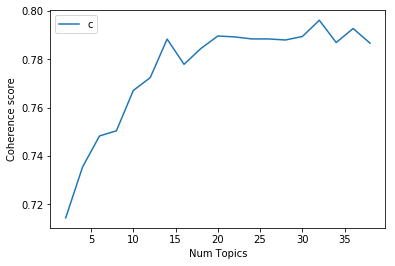

In [55]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7144
Num Topics = 4  has Coherence Value of 0.7355
Num Topics = 6  has Coherence Value of 0.7483
Num Topics = 8  has Coherence Value of 0.7505
Num Topics = 10  has Coherence Value of 0.7672
Num Topics = 12  has Coherence Value of 0.7725
Num Topics = 14  has Coherence Value of 0.7884
Num Topics = 16  has Coherence Value of 0.778
Num Topics = 18  has Coherence Value of 0.7845
Num Topics = 20  has Coherence Value of 0.7897
Num Topics = 22  has Coherence Value of 0.7893
Num Topics = 24  has Coherence Value of 0.7885
Num Topics = 26  has Coherence Value of 0.7885
Num Topics = 28  has Coherence Value of 0.7881
Num Topics = 30  has Coherence Value of 0.7895
Num Topics = 32  has Coherence Value of 0.7962
Num Topics = 34  has Coherence Value of 0.787
Num Topics = 36  has Coherence Value of 0.7928
Num Topics = 38  has Coherence Value of 0.7867


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with **xx topics** itself.

In [60]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.319*"code" + 0.116*"coffee_east" + 0.087*"coffee_peninsula" + 0.058*"bay" '
  '+ 0.029*"wids_pune" + 0.029*"artificial_intelligence" + '
  '0.024*"wimlds_pozna" + 0.014*"theory" + 0.010*"cfp" + 0.010*"curious"'),
 (1,
  '0.117*"woman" + 0.055*"model" + 0.048*"world" + 0.041*"big_data" + '
  '0.034*"ml" + 0.021*"christma" + 0.021*"practical" + 0.021*"nlp" + '
  '0.021*"nairobi" + 0.021*"winter"'),
 (2,
  '0.091*"woman" + 0.079*"bay" + 0.061*"conference" + 0.037*"networking" + '
  '0.037*"happy_hour" + 0.030*"partner_event" + 0.024*"fast" + 0.024*"series" '
  '+ 0.024*"job" + 0.018*"evening"'),
 (3,
  '0.132*"ai" + 0.066*"night" + 0.059*"tensorflow" + 0.053*"day" + '
  '0.039*"deep_learning" + 0.026*"classification" + 0.020*"panel_discussion" + '
  '0.020*"lab" + 0.020*"kick" + 0.020*"center"'),
 (4,
  '0.132*"workshop" + 0.082*"python" + 0.044*"build" + 0.031*"lady" + '
  '0.031*"data_dinner" + 0.025*"technology" + 0.025*"wids_conference" + '
  '0.025*"tech" + 0.025*"share" + 

Those were the topics for the chosen LDA model.

## 18. Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [61]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1132,"woman, model, world, big_data, ml, christma, p...",Big Data: From Chaos to Intelligence
1,1,2.0,0.1172,"woman, bay, conference, networking, happy_hour...",Machine Learning: A Focus on Supervised and Un...
2,2,1.0,0.1091,"woman, model, world, big_data, ml, christma, p...",Deep Learning: Build An Image Classification M...
3,3,1.0,0.1176,"woman, model, world, big_data, ml, christma, p...",NLP: Zero to one
4,4,3.0,0.1365,"ai, night, tensorflow, day, deep_learning, cla...",Handling Imbalanced Datasets: Building a model...
5,5,7.0,0.1154,"machine_learn, talk, introduction, image, work...",The ABC-XYZ of Data Science before Machine Lea...
6,6,6.0,0.1210,"datum, hand, good, analytic, application, grap...",Uncovering patterns and trends using explorato...
7,7,3.0,0.1091,"ai, night, tensorflow, day, deep_learning, cla...",Extracting Your Own Web Data using Scraping Tools
8,8,3.0,0.1296,"ai, night, tensorflow, day, deep_learning, cla...",TensorFlow Post-Summit Event
9,9,0.0,0.1111,"code, coffee_east, coffee_peninsula, bay, wids...",Fueling the Artificial Intelligence revolution...


## 19. Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [62]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(25)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1468,"code, coffee_east, coffee_peninsula, bay, wids...",Code and Coffee East Bay
1,1.0,0.1429,"woman, model, world, big_data, ml, christma, p...",Tales from the World of Health Analytics Strat...
2,2.0,0.1481,"woman, bay, conference, networking, happy_hour...",Why Health Care Needs Another OR (Machine Lear...
3,3.0,0.1429,"ai, night, tensorflow, day, deep_learning, cla...",Night Sky Net: Galaxy Classification using Dee...
4,4.0,0.1587,"workshop, python, build, lady, data_dinner, te...",R + AI Share & Tell (R-Ladies PDX Shared Event)
5,5.0,0.1468,"coffee_sf, event, deep_learn, conference_scree...",Smart Cities Hack
6,6.0,0.1520,"datum, hand, good, analytic, application, grap...",Partner Event: Research Triangle Analysts Annu...
7,7.0,0.1571,"machine_learn, talk, introduction, image, work...",Dr. Vivienne Ming talks about using Machine Le...
8,8.0,0.1548,"data_science, social, event, kickoff, tech, ma...",Halifax Women in Data Science Social (Fireside...
9,9.0,0.1495,"wimld, meetup, coffee, intro, learn, lightning...",WiMLDS x Intuit: Pi Day Meetup


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

## 20. Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [63]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,1.0,"woman, model, world, big_data, ml, christma, p...",96.0,0.2187
1,2.0,"woman, bay, conference, networking, happy_hour...",43.0,0.0979
2,1.0,"woman, model, world, big_data, ml, christma, p...",36.0,0.0820
3,1.0,"woman, model, world, big_data, ml, christma, p...",44.0,0.1002
4,3.0,"ai, night, tensorflow, day, deep_learning, cla...",43.0,0.0979
5,7.0,"machine_learn, talk, introduction, image, work...",29.0,0.0661
6,6.0,"datum, hand, good, analytic, application, grap...",39.0,0.0888
7,3.0,"ai, night, tensorflow, day, deep_learning, cla...",36.0,0.0820
8,3.0,"ai, night, tensorflow, day, deep_learning, cla...",32.0,0.0729
9,0.0,"code, coffee_east, coffee_peninsula, bay, wids...",41.0,0.0934


## 21. Conclusion
We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

Edit: I see some of you are experiencing errors while using the LDA Mallet and I don’t have a solution for some of the issues. So, I’ve implemented a workaround and more useful topic model visualizations. Hope you will find it helpful.